<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">ANALYSES DU DATAFRAME</h1>
</div>

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation du fichier et des librairies</h2>
</div>

OUTLIERS : ATTENTION A INDE (POPULATION) - Valeurs atypiques

Pour la partie analytique, réalise une ACP avec réductions des dimensions et un clustering :
<br>
- Analyse le cercle des corrélations et la projection des individus. <br> 
- Regroupe les pays en utilisant les données de ton ACP ou les données brutes. <br> 
- Commence par la classification ascendante hiérarchique puis un k-means <br>

<div style="border: 1px solid RGB(51,165,182);"> <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies et chargement des fichiers</h3></div>

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import plotly.express as px
import json
import folium
import warnings
import os

from sklearn import decomposition, preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# On charge seaborn
sns.set()

warnings.simplefilter(action='ignore', category=FutureWarning)

In [164]:
df = pd.read_csv('Data/df_final.csv')
df_zone_inde = df[df['Zone'] == 'Inde'].copy()
df.head()

,Zone,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,PIB par habitant,Stabilité politique,Population
0,Afghanistan,1.53,0.54,57.0,-1.53,29.0,2058.4,-2.80,36296113.0
1,Afrique du Sud,35.69,14.11,2118.0,63.00,514.0,13860.3,-0.28,57009756.0
2,Albanie,16.36,6.26,47.0,0.00,38.0,12771.0,0.38,2884169.0
3,Algérie,6.38,1.97,277.0,0.00,2.0,11737.4,-0.92,41389189.0
4,Allemagne,19.47,7.96,1739.0,646.00,842.0,53071.5,0.59,82658409.0


Suite à l'étape 2.6, sur les premiers tests... je décide d'enlever l'Inde du DF.

<img src="./INDE1.png" style="width: 600px; height: 600px;">
<img src="./INDE2.png" style="width: 600px; height: 600px;">

In [165]:
df.drop(df[(df["Zone"] == "Inde")].index, inplace=True)
df.shape

(144, 9)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Data split</h3>
</div>

In [166]:
df.set_index('Zone', inplace=True)
X = df
names = df.index
features = df.columns
features

Index(['Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité intérieure', 'Exportations - Quantité',
       'Importations - Quantité', 'PIB par habitant', 'Stabilité politique',
       'Population'],
      dtype='object')

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Réalisation de l'ACP</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> 2.1 - Scaling</h3>
</div>

In [167]:
#Instantiation
scaler = StandardScaler()

#le fit
scaler.fit(X)

#transformation des données
X_scaled = scaler.transform(X)
X_scaled

array([[-1.21845073, -1.19714191, -0.52551662, ..., -0.8881032 ,
        -3.10211758,  0.25629291],
       [ 1.26685288,  1.52124873,  2.53959079, ..., -0.33937489,
        -0.21527235,  0.76566564],
       [-0.1394972 , -0.05129118, -0.54038857, ..., -0.3900218 ,
         0.54080616, -0.5653459 ],
       ...,
       [ 0.07512943, -0.07332677, -0.10315345, ..., -0.44363508,
         0.02529808, -0.22349932],
       [-1.32030744, -1.29730369, -0.58946598, ..., -0.88981421,
        -1.81907526,  1.98022768],
       [-1.00600675, -1.00282806, -0.60582511, ..., -0.85996913,
         0.33460293, -0.62063005]], shape=(144, 8))

In [168]:
pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5,6,7
count,1.440000e+02,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,1.440000e+02,1.440000e+02,1.440000e+02
mean,1.480297e-16,1.233581e-16,2.775558e-17,-6.167906e-18,0.000000,1.480297e-16,-1.850372e-17,-6.167906e-18
std,1.003490e+00,1.003490e+00,1.003490e+00,1.003490e+00,1.003490,1.003490e+00,1.003490e+00,1.003490e+00
min,-1.320307e+00,-1.297304e+00,-6.058251e-01,-5.073150e-01,-0.481601,-9.413678e-01,-3.102118e+00,-6.280479e-01
25%,-9.159727e-01,-9.477391e-01,-5.493117e-01,-3.239415e-01,-0.466317,-7.569759e-01,-6.190870e-01,-5.364607e-01
50%,-1.147606e-01,-5.229279e-02,-4.459517e-01,-3.187275e-01,-0.384807,-3.556853e-01,4.820955e-02,-3.934305e-01
75%,6.808130e-01,6.122806e-01,-9.720467e-02,-2.313944e-01,-0.061310,4.620103e-01,7.871045e-01,1.048758e-01
max,3.573180e+00,4.277701e+00,5.664186e+00,7.069395e+00,4.964348,4.881246e+00,1.938406e+00,5.871806e+00


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> 2.2 - ACP</h3>
</div>

In [169]:
# On prends les 8 composants
n_components = 8

# On instancie notre ACP
pca = PCA(n_components = n_components)

# On l'entraine sur nos données scalées
pca.fit(X_scaled)

PCA(n_components=8)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> 2.3 - Explained variance & scree plot</h3>
</div>

In [170]:
#Explained variance (ALLER CHERCHER CE QUE CEST)
pca.explained_variance_ratio_

array([0.40459853, 0.26091059, 0.12487818, 0.08104435, 0.06269364,
       0.04100078, 0.02297033, 0.0019036 ])

La première composante capte 40%, la seconde 26%, puis 12%... etc

In [171]:
#Enregistrons cela dans une variable :
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([40.46, 26.09, 12.49,  8.1 ,  6.27,  4.1 ,  2.3 ,  0.19])

In [172]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 40.,  67.,  79.,  87.,  93.,  98., 100., 100.])

In [173]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8]

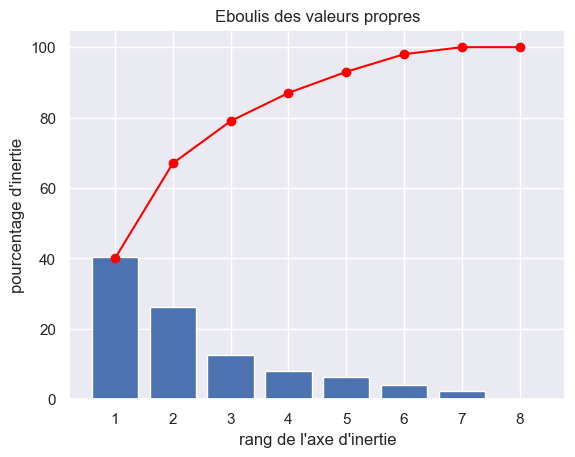

In [174]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

On a en bleu la variance de chaque nouvelle composante, et en rouge la variance cumulée.
On voit ici que près de 80% de la variance est comprise dans les 3 premières composantes, et à plus de 90% dans les 5 premières. 

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> 2.4 - Components</h3>
</div>

In [175]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7
0,0.475669,0.495145,0.245177,0.254209,0.318818,0.429234,0.341844,-0.033040
1,-0.097246,-0.096973,0.546825,0.186029,0.372373,-0.149105,-0.356891,0.599375
2,-0.431680,-0.361556,-0.205297,0.674437,0.255370,0.215754,0.250728,-0.106252
3,0.272266,0.247919,-0.137326,0.548942,-0.037694,-0.453211,-0.475668,-0.333362
4,-0.062853,-0.076778,0.037731,-0.352949,0.754454,-0.280804,0.038248,-0.463296
5,0.019233,-0.047793,0.372985,0.138045,-0.225606,-0.608956,0.645939,-0.014451
6,-0.153378,-0.160835,0.662307,0.018503,-0.269171,0.298192,-0.218919,-0.549834
7,-0.689899,0.720551,0.025944,-0.024429,-0.022517,-0.054583,0.004588,-0.008299


In [176]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs

,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,PIB par habitant,Stabilité politique,Population
F1,0.475669,0.495145,0.245177,0.254209,0.318818,0.429234,0.341844,-0.033040
F2,-0.097246,-0.096973,0.546825,0.186029,0.372373,-0.149105,-0.356891,0.599375
F3,-0.431680,-0.361556,-0.205297,0.674437,0.255370,0.215754,0.250728,-0.106252
F4,0.272266,0.247919,-0.137326,0.548942,-0.037694,-0.453211,-0.475668,-0.333362
F5,-0.062853,-0.076778,0.037731,-0.352949,0.754454,-0.280804,0.038248,-0.463296
F6,0.019233,-0.047793,0.372985,0.138045,-0.225606,-0.608956,0.645939,-0.014451
F7,-0.153378,-0.160835,0.662307,0.018503,-0.269171,0.298192,-0.218919,-0.549834
F8,-0.689899,0.720551,0.025944,-0.024429,-0.022517,-0.054583,0.004588,-0.008299


In [177]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8
Disponibilité alimentaire en quantité (kg/personne/an),0.475669,-0.097246,-0.431680,0.272266,-0.062853,0.019233,-0.153378,-0.689899
Disponibilité de protéines en quantité (g/personne/jour),0.495145,-0.096973,-0.361556,0.247919,-0.076778,-0.047793,-0.160835,0.720551
Disponibilité intérieure,0.245177,0.546825,-0.205297,-0.137326,0.037731,0.372985,0.662307,0.025944
Exportations - Quantité,0.254209,0.186029,0.674437,0.548942,-0.352949,0.138045,0.018503,-0.024429
Importations - Quantité,0.318818,0.372373,0.255370,-0.037694,0.754454,-0.225606,-0.269171,-0.022517
PIB par habitant,0.429234,-0.149105,0.215754,-0.453211,-0.280804,-0.608956,0.298192,-0.054583
Stabilité politique,0.341844,-0.356891,0.250728,-0.475668,0.038248,0.645939,-0.218919,0.004588
Population,-0.033040,0.599375,-0.106252,-0.333362,-0.463296,-0.014451,-0.549834,-0.008299


<Axes: >

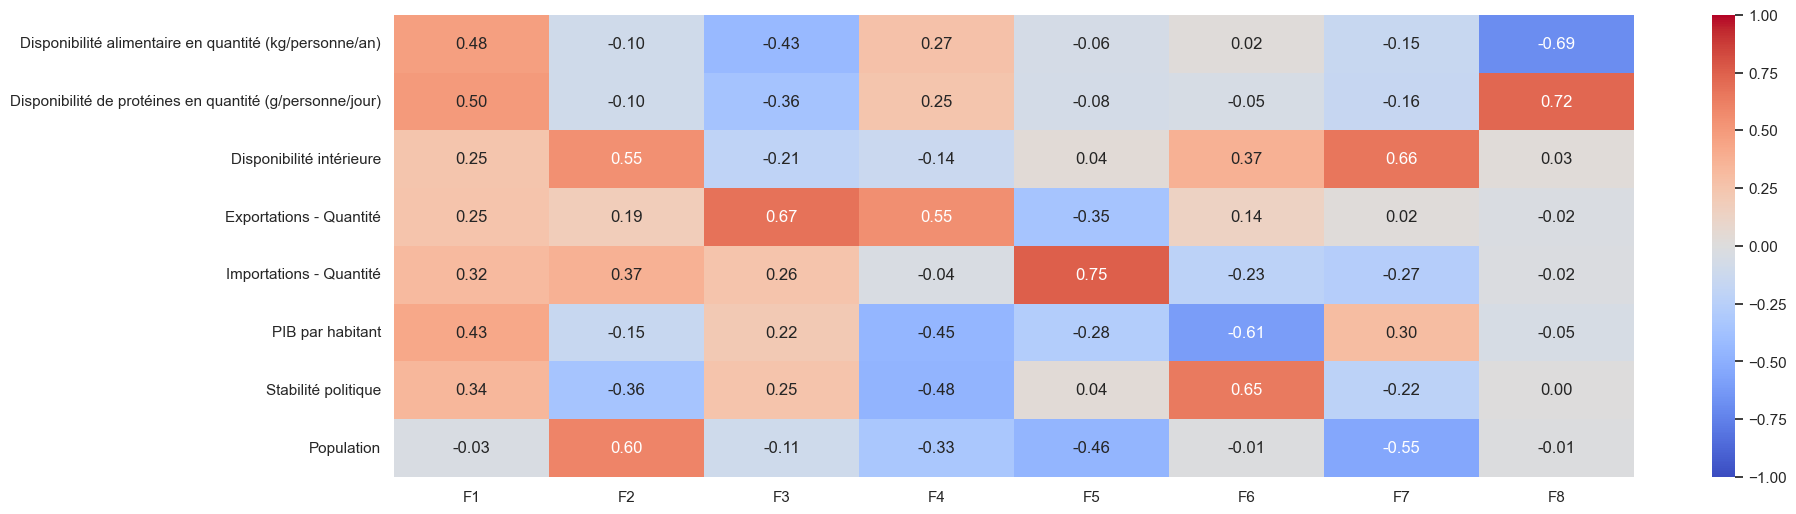

In [178]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
# Le heat map montre les composantes principales 
# F1 la dispo prot est importante dedans
# F8 Rien

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> 2.5 - Corrélation graph</h3>
</div>

In [179]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(5, 5))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [180]:
x_y = (0,1)
x_y

(0, 1)

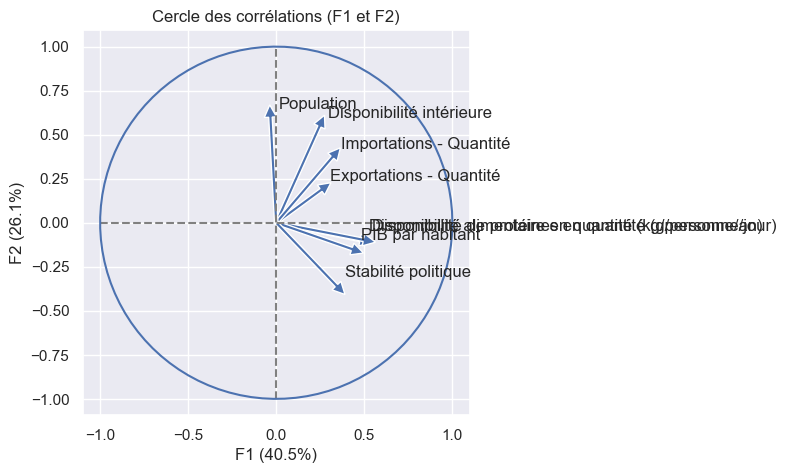

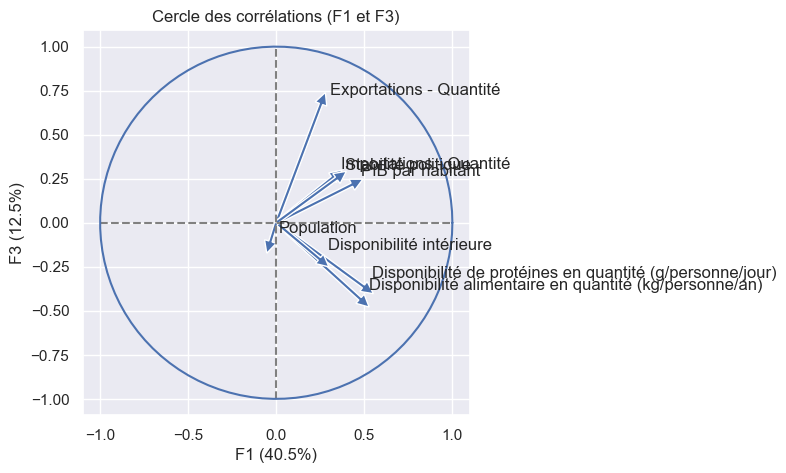

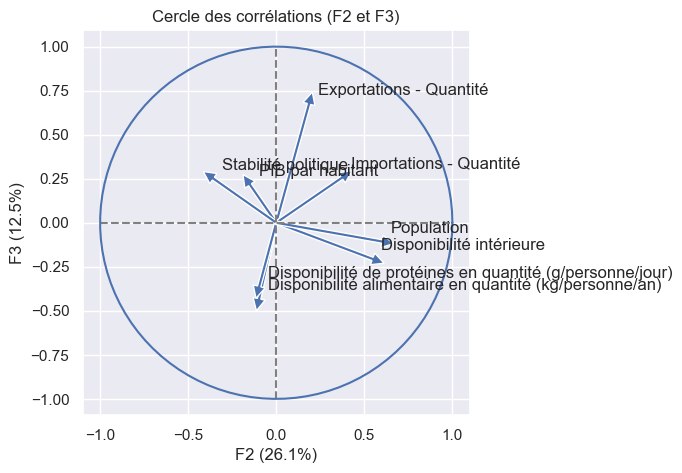

In [181]:
correlation_graph(pca, (0,1), features)
correlation_graph(pca, (0,2), features)
correlation_graph(pca, (1,2), features)

In [182]:
X_proj = pca.transform(X_scaled)

In [183]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

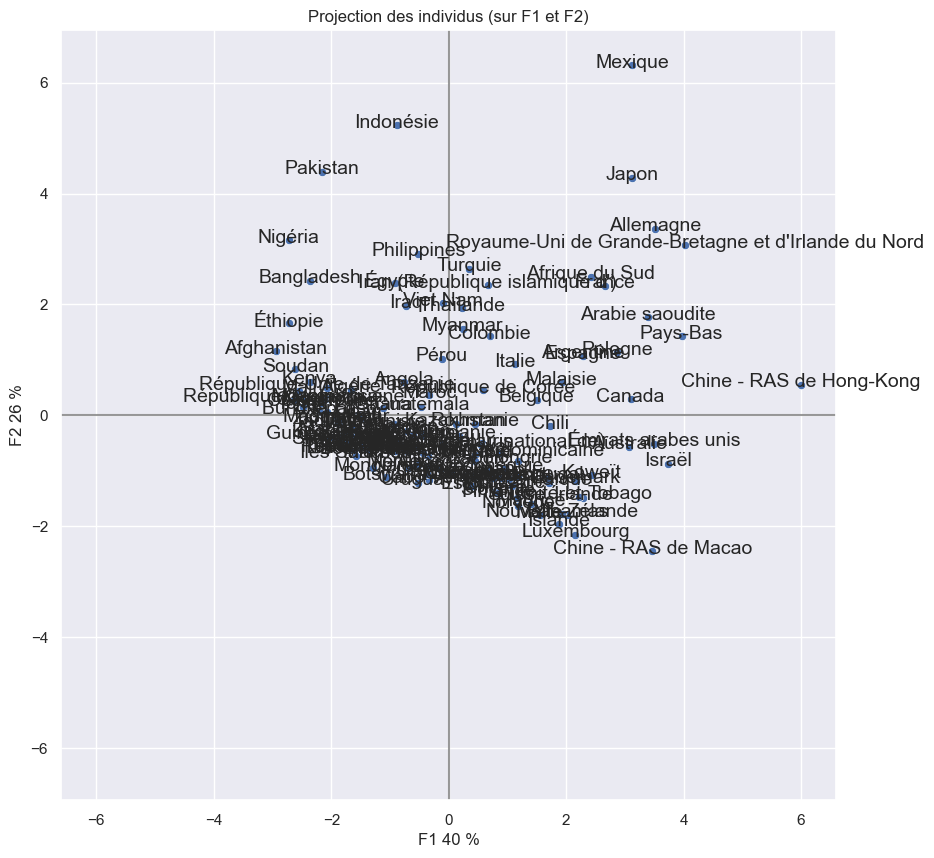

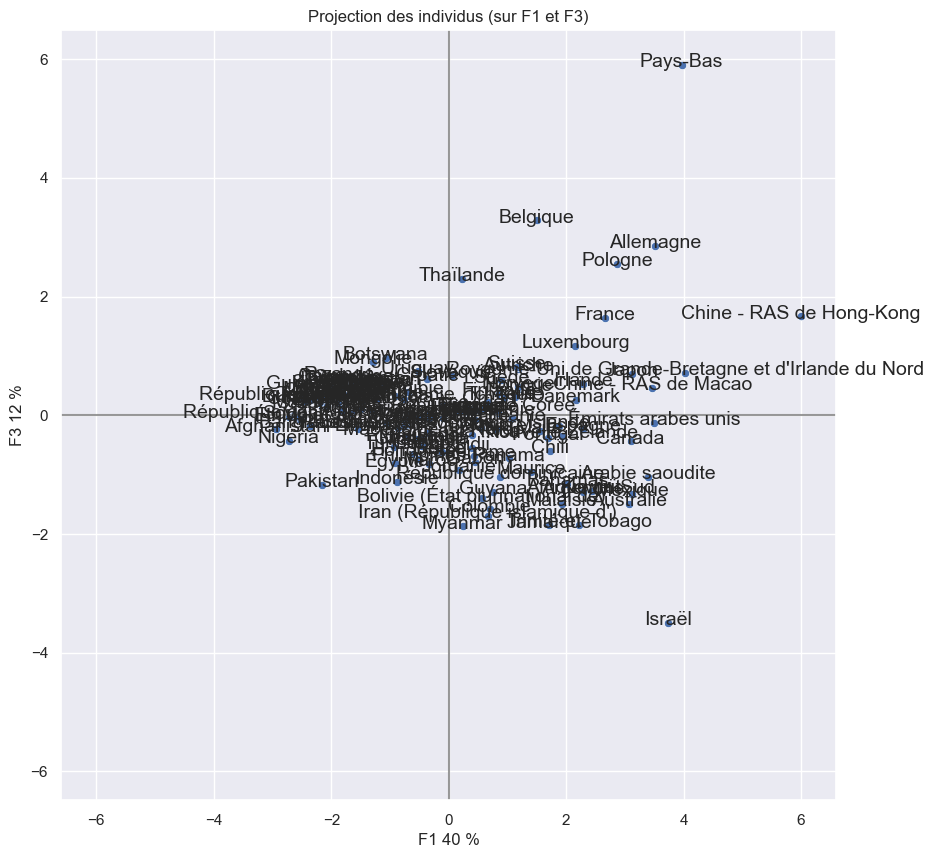

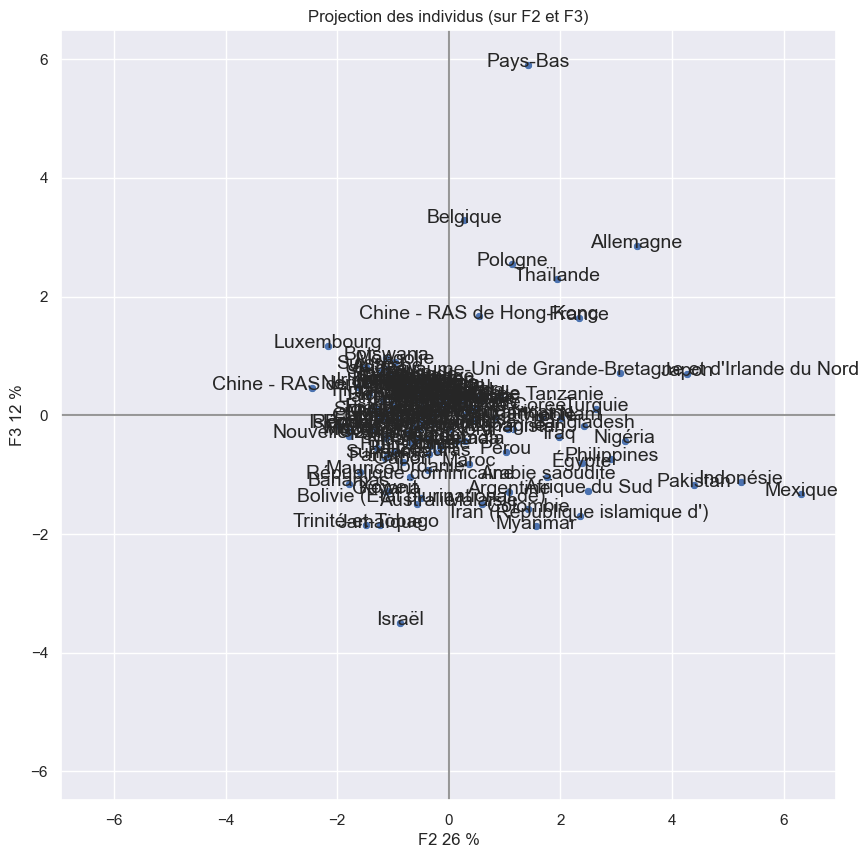

In [184]:
X_proj = pca.transform(X_scaled)
display_factorial_planes(X_proj, (0,1), pca, labels=names, figsize=(10,10), marker="o")
display_factorial_planes(X_proj, (0,2), pca, labels=names, figsize=(10,10), marker="o")
display_factorial_planes(X_proj, (1,2), pca, labels=names, figsize=(10,10), marker="o")

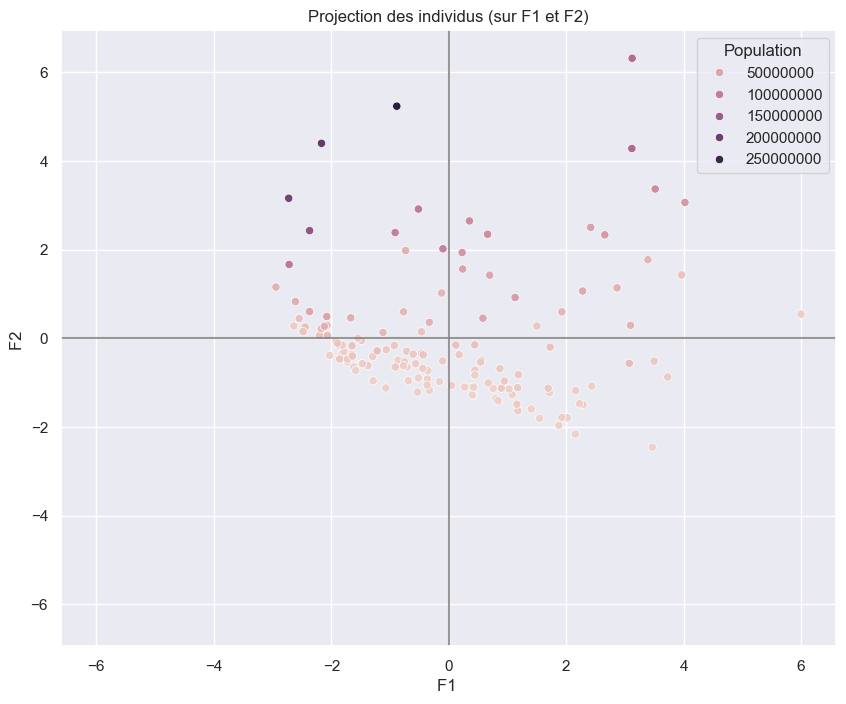

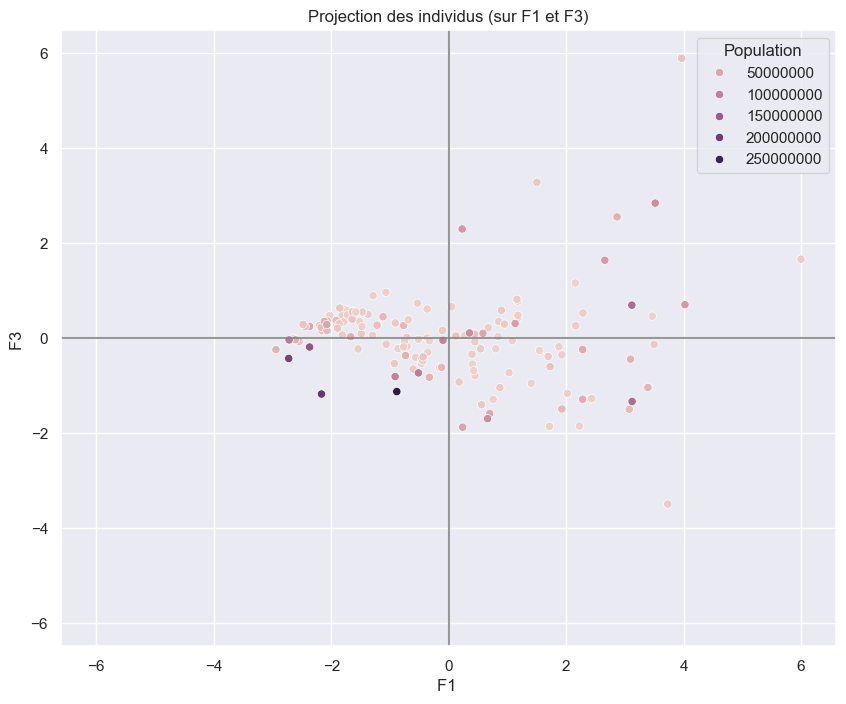

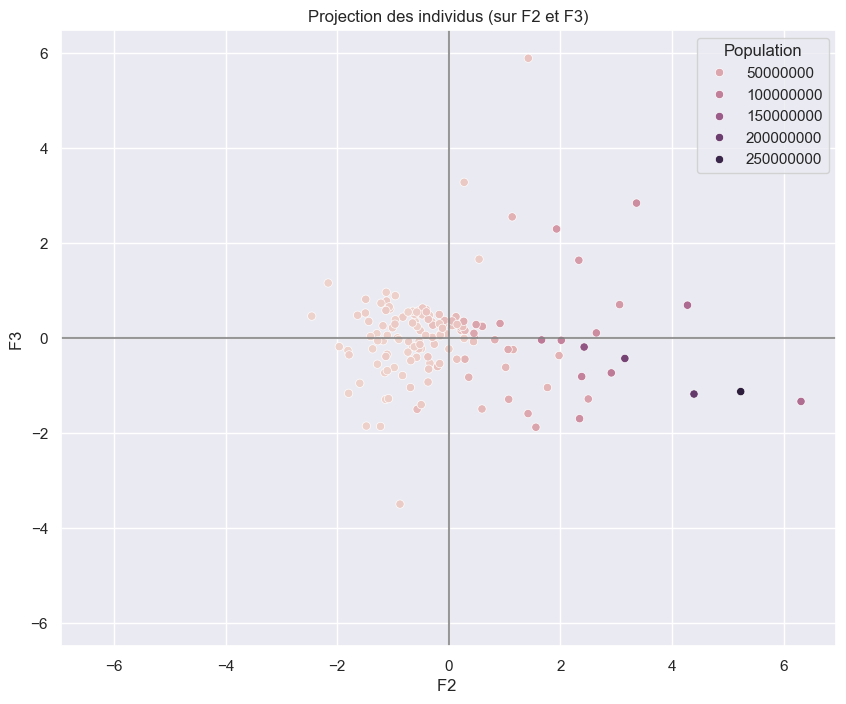

In [185]:
# 'Disponibilité alimentaire en quantité (kg/personne/an)'
# 'Disponibilité de protéines en quantité (g/personne/jour)'
# 'Disponibilité intérieure'
# 'Exportations - Quantité'
# 'Importations - Quantité'
# 'PIB par habitant'
# 'Stabilité politique'
# 'Population'

display_factorial_planes(X_proj, (0,1), clusters=df['Population'])
display_factorial_planes(X_proj, (0,2), clusters=df['Population'])
display_factorial_planes(X_proj, (1,2), clusters=df['Population'])

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> 2.6 - 1ère analyse</h3>
</div>

Au vu de la première étape analytique, le cas de l'Inde semble isolé, je décide donc de reprendre le DF et d'y supprimer l'Inde dans la première étape. 

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Le clusturing</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Classification ascendante hiérarchique  (CAH)</h3>
</div>

In [186]:
# Préparation des données pour le clustering
X = df.values
features = df.index

In [187]:
# On instancie
scaler = StandardScaler()

# On fit
scaler.fit(X)

# On transforme
X_scaled = scaler.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, "ward")

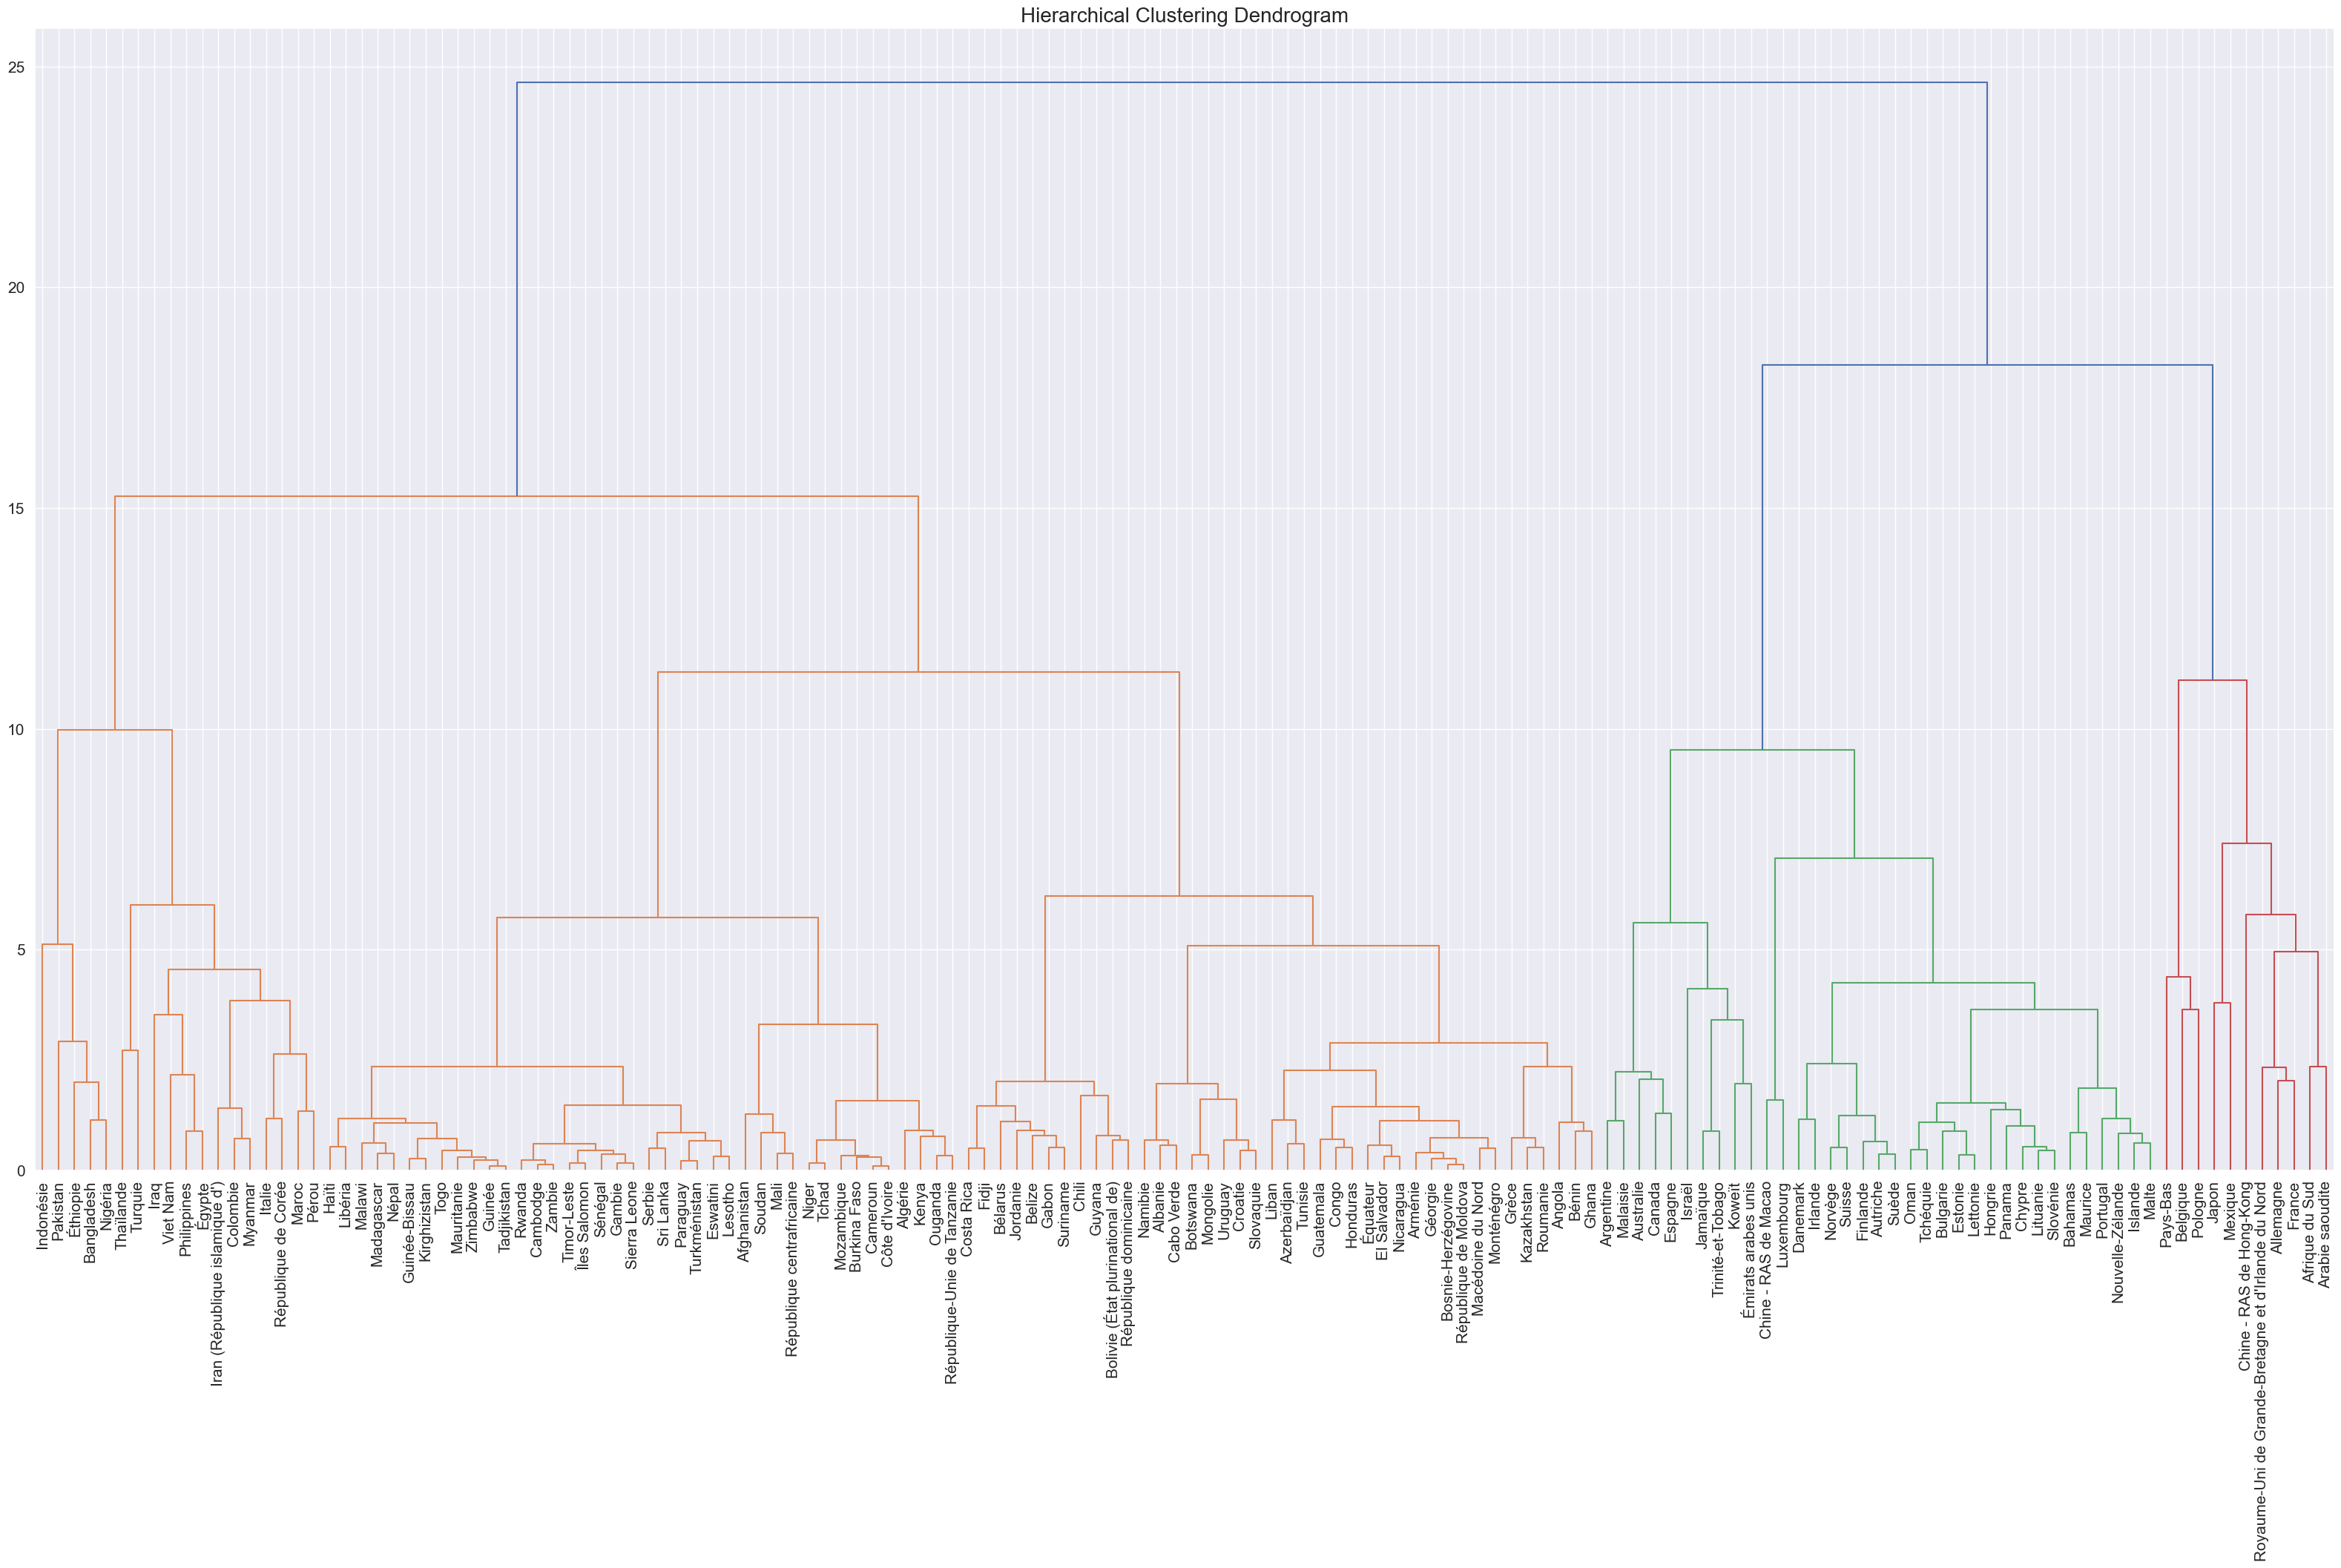

In [188]:
def plot_dendogram(Z, names):
    fig, ax = plt.subplots(1, 1, figsize=(40, 20))

    _ = dendrogram(Z, ax=ax, labels=names, orientation = "top")

    plt.title("Hierarchical Clustering Dendrogram", fontsize=20)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)
    plt.show()
    
plot_dendogram(Z, names)

In [189]:
# Découpage du dendogramme en 8 clusters
clusters = fcluster(Z, 8, criterion="maxclust")
clusters

array([3, 8, 4, 3, 8, 4, 8, 5, 4, 5, 6, 4, 6, 1, 7, 4, 4, 4, 4, 6, 3, 4,
       4, 4, 3, 3, 5, 4, 8, 6, 6, 2, 4, 4, 4, 3, 6, 4, 5, 6, 3, 4, 6, 8,
       4, 3, 4, 4, 4, 3, 3, 4, 4, 3, 4, 6, 1, 2, 2, 6, 6, 5, 2, 5, 8, 4,
       4, 3, 3, 5, 3, 6, 4, 3, 6, 6, 4, 3, 5, 3, 3, 6, 2, 6, 3, 8, 4, 4,
       3, 2, 4, 4, 3, 1, 6, 6, 3, 6, 3, 1, 6, 3, 7, 2, 7, 6, 2, 4, 8, 3,
       3, 2, 4, 4, 3, 3, 3, 4, 6, 3, 3, 6, 4, 6, 3, 3, 3, 6, 2, 3, 3, 5,
       4, 3, 2, 4, 2, 3, 3, 2, 5, 4, 1, 3], dtype=int32)

In [190]:
# Création d'un df pour stocker les clusters avec le pays
df_clusters = pd.DataFrame({
    "cluster" : clusters,
    "Zone" : names
})

display(df_clusters.head())
df_clusters.shape

,cluster,Zone
0,3,Afghanistan
1,8,Afrique du Sud
2,4,Albanie
3,3,Algérie
4,8,Allemagne


(144, 2)

In [191]:
# Nombre de pays par cluster
df_clusters['cluster'].value_counts()

cluster
3    40
4    40
6    25
2    13
5    10
8     8
1     5
7     3
Name: count, dtype: int64

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Visualisation des clusters</h3>
</div>

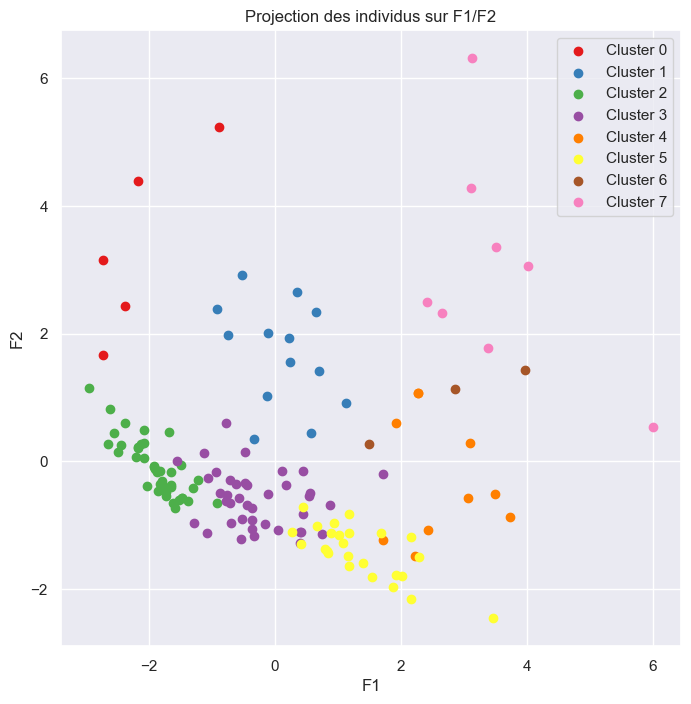

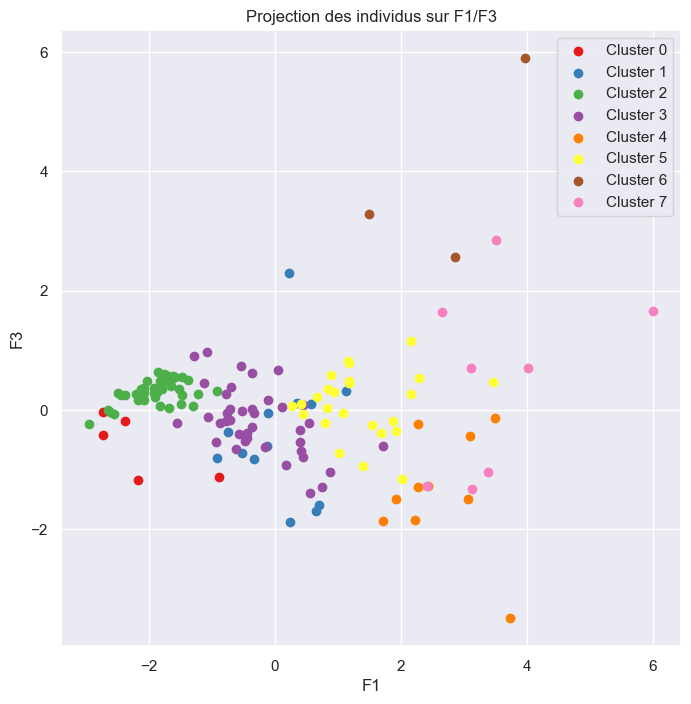

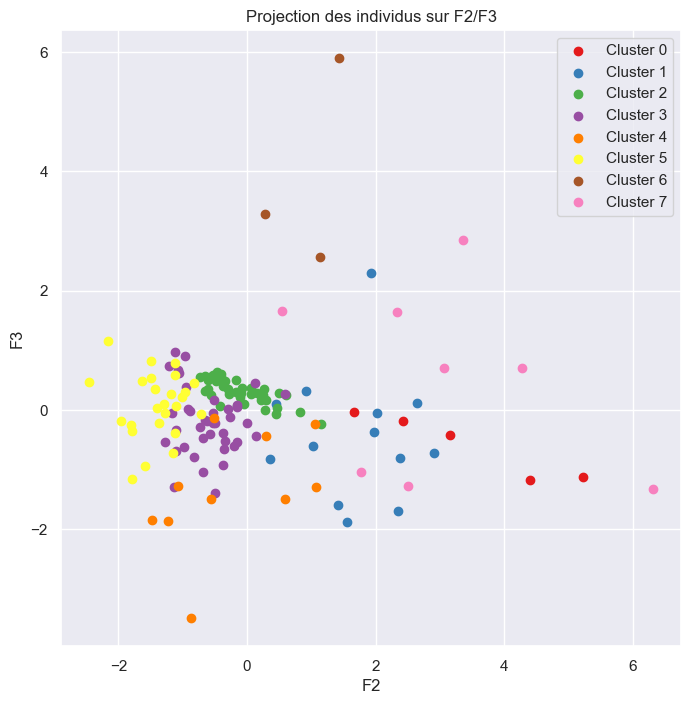

In [192]:
# Remap les clusters pour les rendre consécutifs à partir de 0
encoder = LabelEncoder()
clusters_encoded = encoder.fit_transform(clusters)
# Choisir une palette de couleurs distinctes (ex. Set1 pour 10 couleurs distinctes)
palette = sns.color_palette("Set1", n_colors=len(set(clusters_encoded)))

# Affichage du premier plan factoriel
plt.figure(figsize=(8, 8))
for i in set(clusters_encoded):  # itérer sur chaque cluster
    plt.scatter(X_proj[clusters_encoded == i, 0], X_proj[clusters_encoded == i, 1], 
                label=f'Cluster {i}', 
                color=palette[i])  # Colorier chaque cluster
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Projection des individus sur F1/F2')
plt.legend()
plt.show()

# Affichage du second plan factoriel
plt.figure(figsize=(8, 8))
for i in set(clusters_encoded):  # itérer sur chaque cluster
    plt.scatter(X_proj[clusters_encoded == i, 0], X_proj[clusters_encoded == i, 2], 
                label=f'Cluster {i}', 
                color=palette[i])  # Colorier chaque cluster
plt.xlabel('F1')
plt.ylabel('F3')
plt.title('Projection des individus sur F1/F3')
plt.legend()
plt.show()

# Affichage du troisième plan factoriel
plt.figure(figsize=(8, 8))
for i in set(clusters_encoded):  # itérer sur chaque cluster
    plt.scatter(X_proj[clusters_encoded == i, 1], X_proj[clusters_encoded == i, 2], 
                label=f'Cluster {i}', 
                color=palette[i])  # Colorier chaque cluster
plt.xlabel('F2')
plt.ylabel('F3')
plt.title('Projection des individus sur F2/F3')
plt.legend()
plt.show()


Ce qu'on cherche à montrer :

La répartition des clusters dans différents plans factoriels. <br>
Comment les clusters se répartissent spatialement sur chaque plan. <br>
L'utilisation d'une palette personnalisée permet d'avoir une identification claire des clusters par des couleurs distinctes.

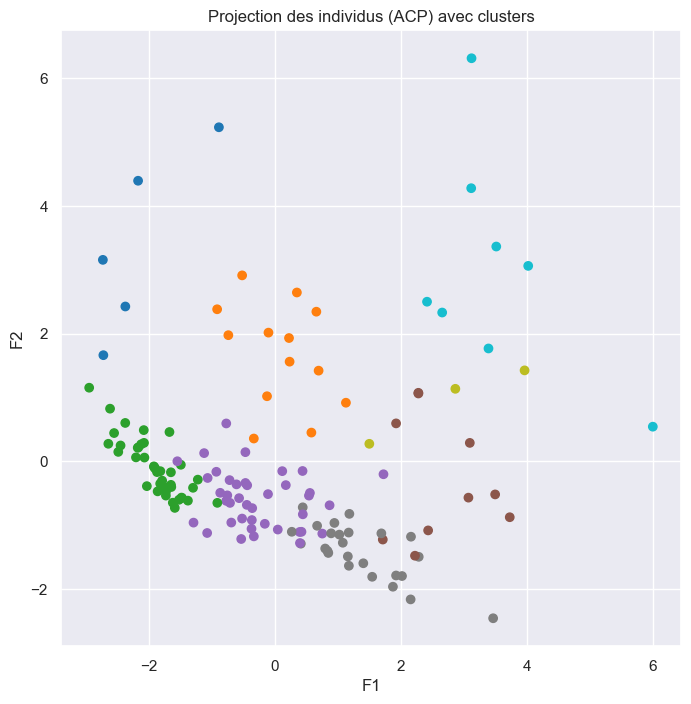

In [193]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Projection des individus (ACP) avec clusters')
plt.show()

Ce qu'on cherche à montrer :

Une vue globale de la répartition des individus dans l'espace des deux premières composantes principales de l'ACP. <br>
Une vue de la séparation ou du chevauchement entre les clusters en fonction des deux principales dimensions qui expliquent la variance des données.<br>
Il n'y a pas de multiples vues de projections, seulement une vue globale qui donne une idée de la structure générale des données.<br>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.3 - K-means  </h3>
</div>


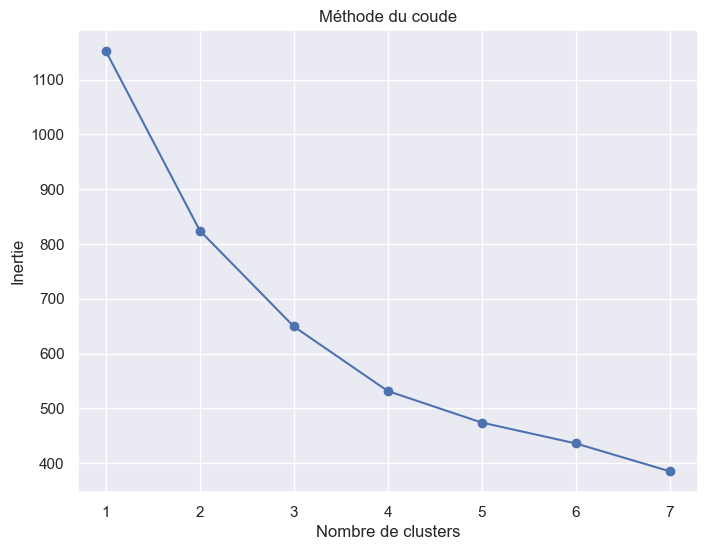

In [194]:
# Méthode du coude : Calcul de l'inertie pour différentes valeurs de k
inertias = []
range_n_clusters = range(1, 8)  # Essayer de 1 à 8 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)  # Appliquer K-means sur les données normalisées
    inertias.append(kmeans.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertias, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

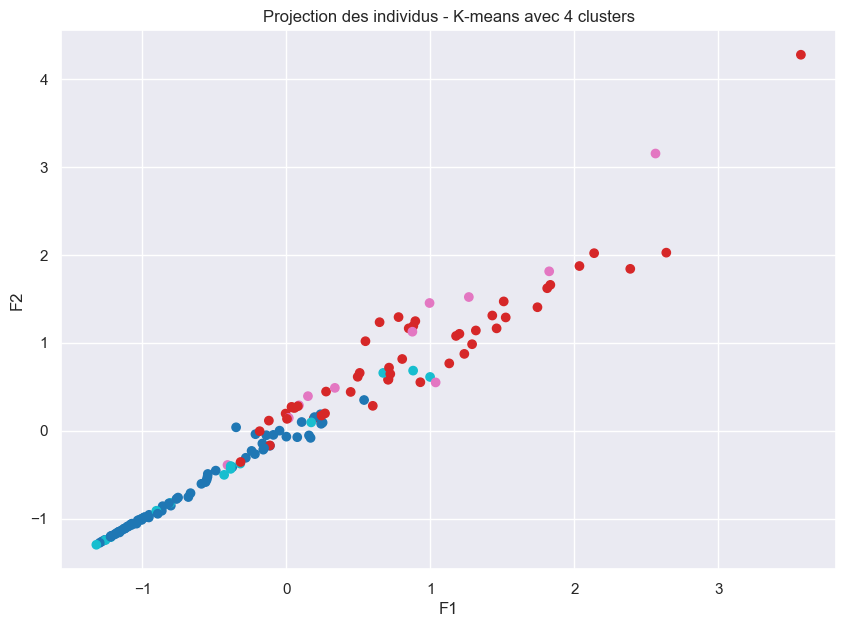

In [195]:
optimal_clusters = 4  # Nombre choisi selon la méthode du coude
df_Kmean = df.copy()
# Appliquer K-means avec 4 clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_scaled)

# Ajouter les labels K-means dans le DataFrame
df_Kmean['kmeans_cluster'] = kmeans.labels_

# Visualisation des clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap='tab10')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Projection des individus - K-means avec 4 clusters')
plt.show()

In [196]:
#df_scaled_clusters = pd.merge(df_scaled, df_clusters, on='Zone')
display(df_Kmean.head())

,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,PIB par habitant,Stabilité politique,Population,kmeans_cluster
Zone,,,,,,,,,
Afghanistan,1.53,0.54,57.0,-1.53,29.0,2058.4,-2.80,36296113.0,0
Afrique du Sud,35.69,14.11,2118.0,63.00,514.0,13860.3,-0.28,57009756.0,2
Albanie,16.36,6.26,47.0,0.00,38.0,12771.0,0.38,2884169.0,0
Algérie,6.38,1.97,277.0,0.00,2.0,11737.4,-0.92,41389189.0,0
Allemagne,19.47,7.96,1739.0,646.00,842.0,53071.5,0.59,82658409.0,2


In [197]:
print(df_Kmean.dtypes)

Disponibilité alimentaire en quantité (kg/personne/an)      float64
Disponibilité de protéines en quantité (g/personne/jour)    float64
Disponibilité intérieure                                    float64
Exportations - Quantité                                     float64
Importations - Quantité                                     float64
PIB par habitant                                            float64
Stabilité politique                                         float64
Population                                                  float64
kmeans_cluster                                                int32
dtype: object


In [198]:
# Moyenne de chaque cluster
df_kmeans_mean = df_Kmean.groupby('kmeans_cluster').agg(['mean'])
display(df_kmeans_mean.head())

,Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,PIB par habitant,Stabilité politique,Population
,mean,mean,mean,mean,mean,mean,mean,mean
kmeans_cluster,,,,,,,,
0,9.032535,3.109859,119.464789,2.035775,33.704225,7810.342254,-0.431268,1.421366e+07
1,30.431429,10.901633,342.551020,44.159796,64.530612,38668.563265,0.603265,1.076196e+07
2,29.197273,11.300909,1608.454545,487.272727,664.727273,41980.963636,0.304545,5.730181e+07
3,13.716923,4.540000,1240.923077,98.336154,57.384615,10452.392308,-1.196154,1.199250e+08


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.4 - Heatmap des clusters</h3>
</div>

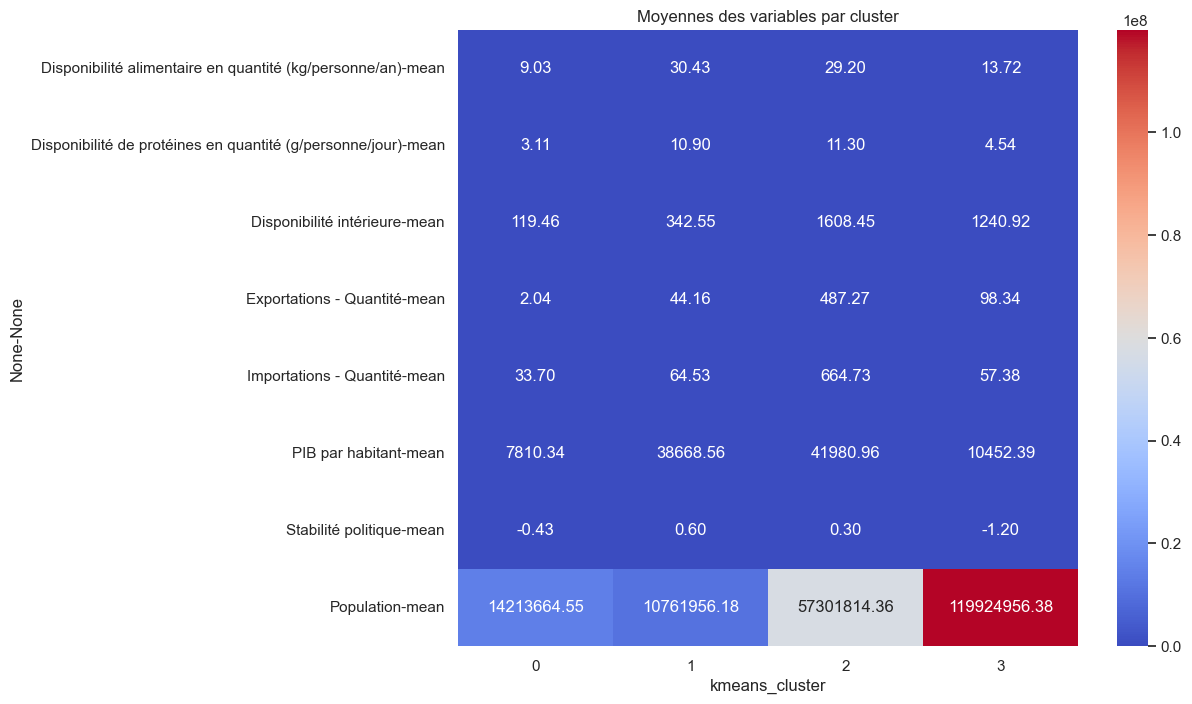

In [199]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_kmeans_mean.T, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Moyennes des variables par cluster')
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.5 - Bloxplot des clusters</h3>
</div>

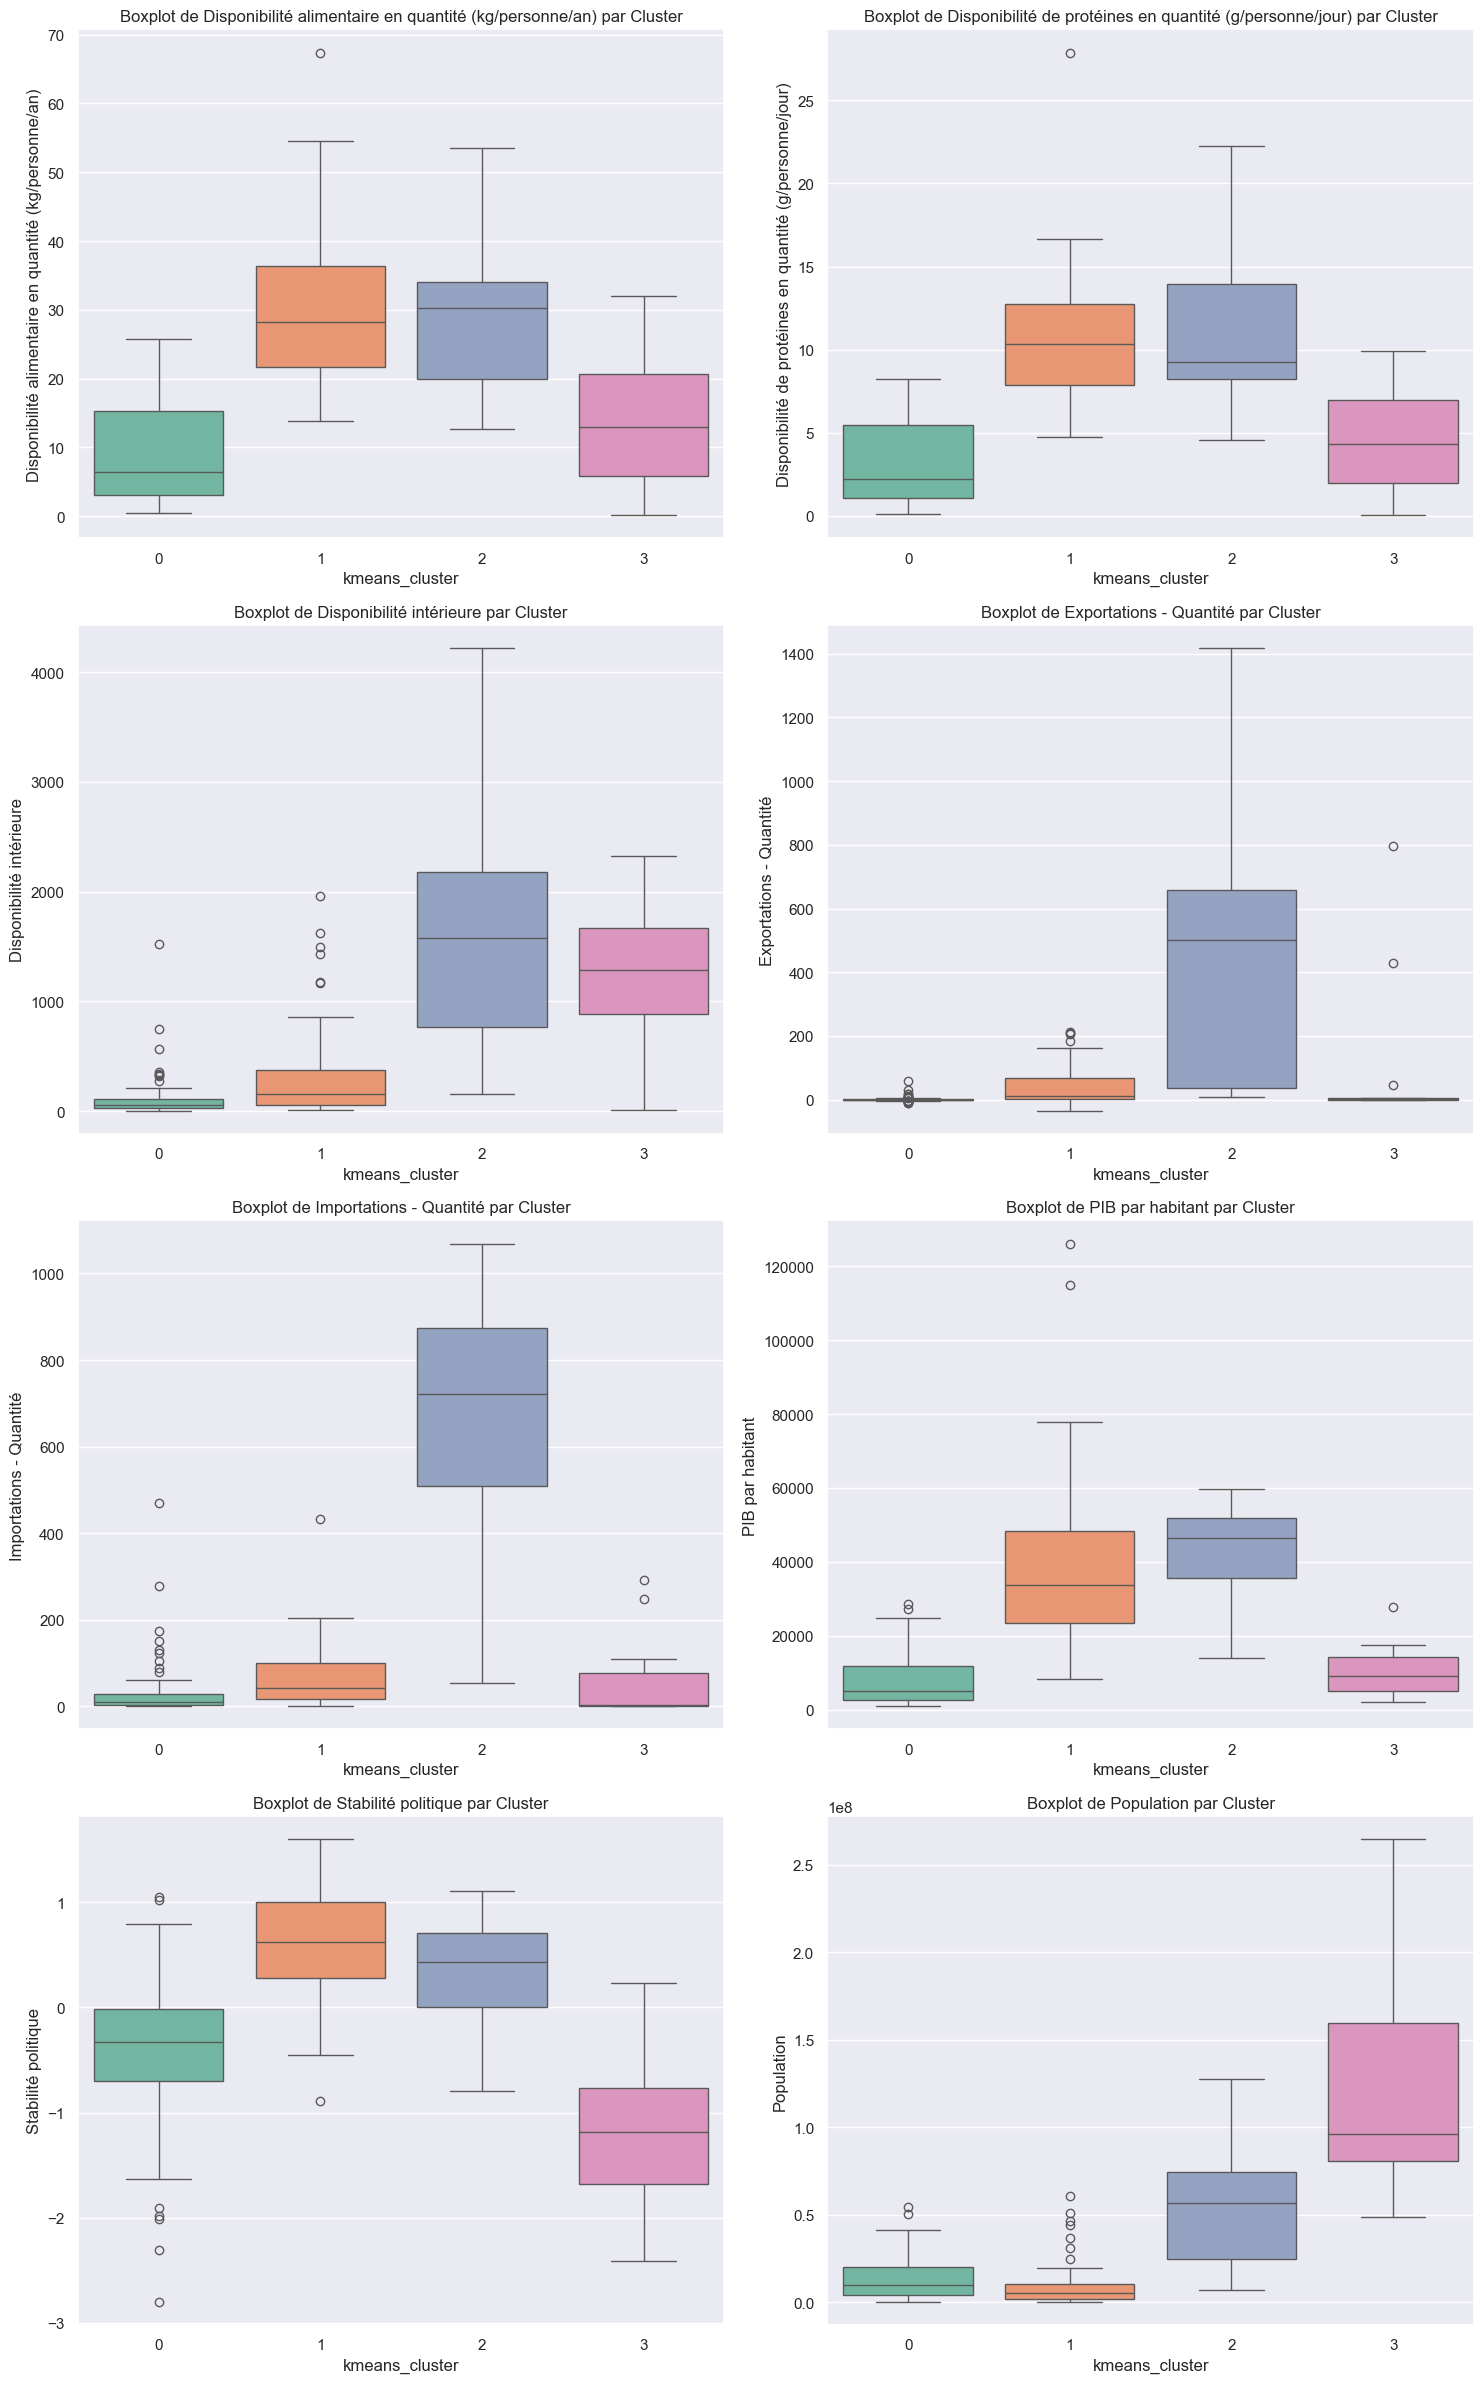

In [200]:
# On ajoute les labels des clusters dans le DataFrame
df_Kmean['kmeans_cluster'] = kmeans.labels_

# Définir la liste des variables
variables = df.columns

n_cols = 2  # Nombre de colonnes (boxplots par ligne)
n_rows = (len(variables) + 1) // n_cols

# Création des boxplots pour chaque variable selon les clusters
plt.figure(figsize=(15, 6 * n_rows))

for i, var in enumerate(variables):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='kmeans_cluster', y=var, data=df_Kmean, palette="Set2")
    plt.title(f'Boxplot de {var} par Cluster')

plt.tight_layout()
plt.show()


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyse</h2>
</div>

La classification ascendante hiérarchique (CAH) propose un découpage naturel en 8 clusters, observé à travers le dendrogramme. En revanche, la méthode du coude appliquée au KMeans suggère une solution optimale autour de 4 clusters, qui correspond à un équilibre entre homogénéité intra-cluster et simplicité d'interprétation.
Ce décalage est fréquent car la CAH tend à découper les données de manière plus fine, tandis que le KMeans recherche une partition plus compacte et globalement homogène. Dans ce contexte, le choix final entre 4 et 8 dépendra des besoins en granularité de l'analyse : <br>
— Une solution à 4 clusters fournit une vue synthétique des grandes tendances.<br>
— Une solution à 8 clusters permet d'identifier des sous-groupes plus spécifiques.<br>

In [201]:
# Trier le DataFrame selon la colonne choisi
df_export_sorted = df.sort_values('Exportations - Quantité', ascending=False)
print(df_export_sorted[['Exportations - Quantité']].head(10))

# Afficher les clusters et les pays associés à chaque cluster
for cluster in sorted(df_Kmean['kmeans_cluster'].unique()):
    print(f"\nCluster {cluster}:")
    
    # Filtrer le DataFrame par cluster
    cluster_countries = df_Kmean[df_Kmean['kmeans_cluster'] == cluster]
    
    # Afficher les pays associés au cluster en accédant à l'index
    print(cluster_countries.index.tolist())  # L'index contient les noms des pays

#faire ca pour chaque colonne

                                                    Exportations - Quantité
Zone                                                                       
Pays-Bas                                                             1418.0
Pologne                                                              1025.0
Thaïlande                                                             796.0
Chine - RAS de Hong-Kong                                              663.0
Belgique                                                              656.0
Allemagne                                                             646.0
France                                                                501.0
Turquie                                                               429.0
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                    359.0
Espagne                                                               212.0

Cluster 0:
['Afghanistan', 'Albanie', 'Algérie', 'Angola', 'Arménie', 'Azerbaïdjan', 'B

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Cartes des clusters</h3>
</div>

In [202]:
#créer un tableau avec les cluster pour chaque Zone et demander a GPT d'y ajouter les coordonnées gps, le tout en JSON

In [203]:
with open('paysGPS.json', 'r', encoding='utf-8') as f:
    paysGPS = json.load(f)

# Convertir en DataFrame
df_paysGPS = pd.DataFrame.from_dict(paysGPS, orient='index', columns=['Latitude', 'Longitude', 'Cluster'])

# Afficher le nombre de lignes
print(df_paysGPS.shape)

(144, 3)


In [204]:
# Définition des couleurs pour chaque cluster
cluster_colors = {
    0: 'blue',   # Cluster 0
    1: 'green',  # Cluster 1
    2: 'red',    # Cluster 2
    3: 'purple'  # Cluster 3
}

# Création de la carte du monde avec des limites de zoom
for country, coord in df_paysGPS.iterrows():
    cluster = coord['Cluster']  # Récupérer le numéro de cluster
    cluster_color = cluster_colors[cluster]  # Déterminer la couleur du cluster

    # Ajouter le marqueur avec la couleur associée au cluster
    folium.CircleMarker(
        location=[coord['Latitude'], coord['Longitude']],  # Latitude et Longitude
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7
    ).add_to(map)


# Ajouter une légende simple avec des couleurs par cluster
legend_html = """
     <div style="position: fixed; 
                 bottom: 150px; left: 30px; width: 120px; height: 170px; 
                 border:2px solid grey; background-color:white; z-index:9999;
                 font-size:14px; font-weight: bold; padding: 10px;">
     <p style="text-align:center;">Légende des clusters</p>
     <div><i style="background:blue; width: 18px; height: 18px; display: inline-block;"></i> Cluster 0</div>
     <div><i style="background:green; width: 18px; height: 18px; display: inline-block;"></i> Cluster 1</div>
     <div><i style="background:red; width: 18px; height: 18px; display: inline-block;"></i> Cluster 2</div>
     <div><i style="background:purple; width: 18px; height: 18px; display: inline-block;"></i> Cluster 3</div>
     </div>
"""

# Ajouter la légende à la carte
map.get_root().html.add_child(folium.Element(legend_html))

# Affichage de la carte
map


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Choix des clusters</h3>
</div>

In [213]:
# Résumé des informations récupérées
creationData = {
    "Cluster": ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"],
    "Exportation": [
        "✅ : Faible développement économique, souvent déficit local — forte demande pour des produits abordables comme le poulet.",
        "❌ : Déjà des producteurs et exportateurs solides, moins de place pour des concurrents étrangers.",
        "🟰 : Déjà de grands flux commerciaux, présence de gros acteurs — possible si niche ou partenariat ciblé.",
        "✅ : Pays en croissance avec population énorme, souvent besoins dépassant la production locale."
    ],
    "Importation": [
        "✅ : Souvent dépendants des importations pour la volaille, potentiel intéressant à condition de rester compétitif sur le prix.",
        "❌ : Importations souvent faibles car autosuffisance ou circuits commerciaux fermés.",
        "✅ : Forts volumes d’importations existants, marchés ouverts mais compétitifs.",
        "✅ : Fort volume d’importation nécessaire pour subvenir à la demande intérieure croissante."
    ],
    "Disponibilité alimentaire": [
        "❌ : La disponibilité alimentaire est faible, signe de faibles moyens d'achat — attention à l'accessibilité économique.",
        "✅ : Haute disponibilité alimentaire, bon pouvoir d’achat pour des produits différenciés (qualité, label, halal).",
        "✅ : Bonne disponibilité alimentaire, donc capacité d’achat présente.",
        "❌ : Disponibilité alimentaire parfois faible, distribution inégale selon les zones."
    ],
    "Disponibilité en protéines": [
        "❌ : Faible consommation de protéines animales, signalant souvent des habitudes alimentaires limitées ou contraintes économiques.",
        "✅ : Forte consommation de protéines — marché mature, demande diversifiée.",
        "✅ : Bonne consommation de protéines animales, clients habitués à la volaille.",
        "🟰 : Consommation de protéines en progression mais encore faible, marché à éduquer et à développer."
    ],
    "Disponibilité intérieure": [
        "✅ : Faible production locale, donc besoin de complémenter par des importations.",
        "❌ : Bonne production locale, saturation probable du marché.",
        "🟰 : Production locale significative, il faudra se différencier sur la qualité ou le prix.",
        "✅ : Production intérieure souvent insuffisante par rapport à la population, importations nécessaires."
    ],
    "PIB par habitant": [
        "❌ : PIB faible, limite le pouvoir d’achat — priorité au prix bas.",
        "✅ : PIB élevé, clientèle prête à payer pour de la qualité supérieure ou pour des standards éthiques.",
        "✅ : PIB généralement élevé ou moyen, capacité d’achat correcte.",
        "❌ : PIB souvent bas ou moyen, prix de vente limité."
    ],
    "Stabilité politique": [
        "❌ : Instabilité fréquente, donc risques logistiques et commerciaux élevés.",
        "✅ : Stabilité politique, sécurité des contrats et des échanges commerciaux.",
        "✅ : Stabilité relativement bonne, cadre contractuel fiable.",
        "❌ : Instabilité fréquente (politique ou logistique), risques pour les échanges."
    ],
    "Population": [
        "✅ : Marchés de taille modeste mais cumulés, représentent une base large et croissante en Afrique, Asie centrale et Amérique latine.",
        "❌ : Petits pays ou marchés saturés, potentiel limité en volume brut.",
        "✅ : Marchés denses, populations urbaines nombreuses — forte demande potentielle.",
        "✅ : Populations massives, demande potentielle énorme si le produit est accessible économiquement."
    ]
}

df_tableau_resume = pd.DataFrame(creationData)

html = df_tableau_resume.to_html(index=False)

with open("tableau_poulet.html", "w", encoding='utf-8') as f:
    f.write(html)

Cluster 0 <br>
La demande locale est élevée en raison de faibles niveaux de production locale et de développement économique, ce qui crée une forte dépendance aux importations.<br>
Avantages : Ces marchés offrent un potentiel intéressant, surtout si l'on peut maintenir des prix compétitifs tout en répondant aux besoins alimentaires essentiels des populations.<br><br>
Cluster 1<br>
Ce cluster présente des marchés déjà saturés avec des producteurs locaux bien établis et une autosuffisance ou des circuits commerciaux fermés, rendant l'entrée difficile.<br>
Inconvénients : La forte concurrence locale et les faibles possibilités d'intégration pour les exportateurs étrangers rendent ce marché peu favorable à de nouvelles exportations de volaille.<br><br>
Cluster 2<br>
Le marché est ouvert avec une forte demande et une bonne capacité d’importation, offrant ainsi des opportunités, notamment pour des produits différenciés ou en niches.<br>
Avantages : La consommation de protéines est bonne, et la stabilité politique est favorable, ce qui permet une implantation plus sereine sur ces marchés.<br><br>
Cluster 3<br>
Ce cluster regroupe des pays en forte croissance avec une population massive et une demande croissante en volaille, mais une production locale insuffisante pour répondre aux besoins.<br>
Avantages : Les importations sont nécessaires pour compléter l'offre locale, offrant une opportunité de répondre à une demande alimentaire en plein essor, tout en bénéficiant de marchés à fort potentiel.<br><br>
Conclusion :<br>
Les clusters les plus intéressants pour l'exportation de volaille sont les Cluster 0, Cluster 2, et Cluster 3. Ils offrent de bonnes opportunités en raison de la demande élevée, de la faible production locale et de l'ouverture aux importations.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Analyse spécifique des clusters 0, 2 et 3</h3>
</div>

In [206]:
df_Kmean = df_Kmean.reset_index()
df_filtered = df_Kmean[df_Kmean["kmeans_cluster"] != 1]
df_filtered = df_filtered.rename(columns={'kmeans_cluster' : 'cluster'})

In [207]:
df_filtered.columns

Index(['Zone', 'Disponibilité alimentaire en quantité (kg/personne/an)',
       'Disponibilité de protéines en quantité (g/personne/jour)',
       'Disponibilité intérieure', 'Exportations - Quantité',
       'Importations - Quantité', 'PIB par habitant', 'Stabilité politique',
       'Population', 'cluster'],
      dtype='object')

In [ ]:
def calculer_score(row, stats):
    score = 0

    # Plus le PIB est haut, plus il y a d'argent.
    if row['PIB par habitant'] > stats['PIB par habitant']['mean']:
        score += 2
    else:
        score += 1

    # Plus les importations sont élevés, plus il a de besoin
    if row['Importations - Quantité'] > stats['Importations - Quantité']['mean']:
        score += 2
    else:
        score += 1

    # une bonne stabilité est préférable pour le commerce
    if row['Stabilité politique'] > stats['Stabilité politique']['mean']:
        score += 2
    else:
        score += 1

    # plus de population, plus de ventes.
    if row['Population'] > stats['Population']['mean']:
        score += 2
    else:
        score += 1

    # moins il y a de dispo alimentaire plus y'a de besoin
    if row['Disponibilité alimentaire en quantité (kg/personne/an)'] > stats['Disponibilité alimentaire en quantité (kg/personne/an)']['mean']:
        score += 2
    else:
        score += 1

    # moins il y a de dispo alimentaire plus y'a de besoin
    if row['Disponibilité de protéines en quantité (g/personne/jour)'] > stats['Disponibilité de protéines en quantité (g/personne/jour)']['mean']:
        score += 2
    else:
        score += 1

    # moins il y a de disponibilité intérieur mieux c'est 
    if row['Disponibilité intérieure'] < stats['Disponibilité intérieure']['mean']:
        score += 2
    else:
        score += 1

    # Une faible exportation est mieux 
    if row['Exportations - Quantité'] < stats['Exportations - Quantité']['mean']:
        score += 2
    else:
        score += 1

    return score


# Calculer de la moyenne pour chaque colonne.
stats = {
    'PIB par habitant': {
        'mean': df_filtered['PIB par habitant'].mean(),
    },
    'Importations - Quantité': {
        'mean': df_filtered['Importations - Quantité'].mean(),
    },
    'Stabilité politique': {
        'mean': df_filtered['Stabilité politique'].mean(),
    },
    'Population': {
        'mean': df_filtered['Population'].mean(),
    },
    'Disponibilité alimentaire en quantité (kg/personne/an)': {
        'mean': df_filtered['Disponibilité alimentaire en quantité (kg/personne/an)'].mean(),
    },
    'Disponibilité de protéines en quantité (g/personne/jour)': {
        'mean': df_filtered['Disponibilité de protéines en quantité (g/personne/jour)'].mean(),
    },
    'Disponibilité intérieure': {
        'mean': df_filtered['Disponibilité intérieure'].mean(),
    },
    'Exportations - Quantité': {
        'mean': df_filtered['Exportations - Quantité'].mean(),
    }
}

# Appliquer la fonction de calcul de score à chaque ligne du DataFrame filtré
df_filtered['Score'] = df_filtered.apply(lambda row: calculer_score(row, stats), axis=1)

moyenne_score = df_filtered['Score'].mean() #11,9

# Filtrer les meilleurs pays en fonction du score
df_meilleurs_pays = df_filtered[df_filtered['Score'] > 12]


# Trier les pays de la meilleure note à la moins bonne
df_meilleurs_pays_sorted = df_meilleurs_pays.sort_values(by='Score', ascending=False)

# Afficher les meilleurs pays triés par score
print(df_meilleurs_pays_sorted[['Zone','Score','cluster']].head(25))
#je choisi de prendre les pays avec plus de 13 au score.

                                                  Zone  Score  cluster
1                                       Afrique du Sud     15        2
66                                          Kazakhstan     15        0
64                                               Japon     15        2
85                                             Mexique     14        2
76                                   Macédoine du Nord     14        0
2                                              Albanie     14        0
52                                             Géorgie     14        0
102                                           Pays-Bas     14        2
47                                               Grèce     14        0
43                                              France     14        2
87                                          Monténégro     14        0
28                            Chine - RAS de Hong-Kong     14        2
22                                               Bénin     14        0
17    

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Choix des pays</h3>
</div>

In [217]:
# Liste de sélection
pays_selection = [
"Afrique du Sud",
"Kazakhstan",
"Japon",
"Géorgie",
"Pays-Bas",
"Monténégro",
"Mexique",
"Macédoine du Nord",
"Grèce",
"Albanie",
"France",
"Chine - RAS de Hong-Kong",
"Bénin",
"Bosnie-Herzégovine",
"Belgique",
"Allemagne",
"Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"
]

# Filtrage du DataFrame
df_filtre = df_paysGPS.loc[df_paysGPS.index.isin(pays_selection)]

# CREATION D'UNE NOUVELLE CARTE VIDE
map_filtre = folium.Map(location=[0, 0], zoom_start=2, min_zoom=2, max_zoom=5)

# Boucle sur les pays filtrés
for country, coord in df_filtre.iterrows():
    cluster = coord['Cluster']
    cluster_color = cluster_colors[cluster]

    folium.CircleMarker(
        location=[coord['Latitude'], coord['Longitude']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7
    ).add_to(map_filtre)

# Légende
legend_html = """
     <div style="position: fixed; 
                 bottom: 150px; left: 30px; width: 120px; height: 120px; 
                 border:2px solid grey; background-color:white; z-index:9999;
                 font-size:14px; font-weight: bold; padding: 10px;">
     <p style="text-align:center;">Legende des clusters</p>
     <div><i style="background:blue; width: 18px; height: 18px; display: inline-block;"></i> Cluster 0</div>
     <div><i style="background:red; width: 18px; height: 18px; display: inline-block;"></i> Cluster 2</div>
     </div>
"""
map_filtre.get_root().html.add_child(folium.Element(legend_html))

# Affichage de la carte filtrée
map_filtre

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.4 - Et l'Inde finalement ?</h3>
</div>

In [218]:
df_filtered_inde = pd.concat([df_filtered, df_zone_inde])

In [211]:
def calculer_score(row, stats):
    score = 0

    # Ajuster les seuils pour le PIB par habitant
    # Plus le PIB est haut, plus il y a d'argent.
    if row['PIB par habitant'] > stats['PIB par habitant']['mean']:
        score += 2
    else:
        score += 1

    # Ajuster les seuils pour les importations
    # Plus les importations sont élevés, plus il a de besoin
    if row['Importations - Quantité'] > stats['Importations - Quantité']['mean']:
        score += 2
    else:
        score += 1

    # Ajouter un score basé sur la stabilité politique
    # une bonne stabilité est préférable pour le commerce
    if row['Stabilité politique'] > stats['Stabilité politique']['mean']:
        score += 2
    else:
        score += 1

    # Ajouter un score basé sur la population
    # plus de population, plus de ventes.
    if row['Population'] > stats['Population']['mean']:
        score += 2
    else:
        score += 1

    # Ajouter un score basé sur la Disponibilité alimentaire en quantité (kg/personne/an)
    # moins il y a de dispo alimentaire plus y'a de besoin
    if row['Disponibilité alimentaire en quantité (kg/personne/an)'] > stats['Disponibilité alimentaire en quantité (kg/personne/an)']['mean']:
        score += 2
    else:
        score += 1

    # Ajouter un score basé sur la Disponibilité de protéines en quantité (g/personne/jour)
    # moins il y a de dispo alimentaire plus y'a de besoin
    if row['Disponibilité de protéines en quantité (g/personne/jour)'] > stats['Disponibilité de protéines en quantité (g/personne/jour)']['mean']:
        score += 2
    else:
        score += 1

    # Ajouter un score basé sur la Disponibilité intérieure
    # moins il y a de disponibilité intérieur mieux c'est 
    if row['Disponibilité intérieure'] < stats['Disponibilité intérieure']['mean']:
        score += 2
    else:
        score += 1

    # Ajouter un score basé sur l'Exportations - Quantité
    # Une faible exportation est mieux 
    if row['Exportations - Quantité'] < stats['Exportations - Quantité']['mean']:
        score += 2
    else:
        score += 1

    return score


# Calculer les statistiques (min, mean, max) pour chaque colonne
stats = {
    'PIB par habitant': {
        'mean': df_filtered['PIB par habitant'].mean(),
    },
    'Importations - Quantité': {
        'mean': df_filtered['Importations - Quantité'].mean(),
    },
    'Stabilité politique': {
        'mean': df_filtered['Stabilité politique'].mean(),
    },
    'Population': {
        'mean': df_filtered['Population'].mean(),
    },
    'Disponibilité alimentaire en quantité (kg/personne/an)': {
        'mean': df_filtered['Disponibilité alimentaire en quantité (kg/personne/an)'].mean(),
    },
    'Disponibilité de protéines en quantité (g/personne/jour)': {
        'mean': df_filtered['Disponibilité de protéines en quantité (g/personne/jour)'].mean(),
    },
    'Disponibilité intérieure': {
        'mean': df_filtered['Disponibilité intérieure'].mean(),
    },
    'Exportations - Quantité': {
        'mean': df_filtered['Exportations - Quantité'].mean(),
    }
}

# Appliquer la fonction de calcul de score à chaque ligne du DataFrame filtré
df_zone_inde['Score'] = df_zone_inde.apply(lambda row: calculer_score(row, stats), axis=1)

# Trier les pays de la meilleure note à la moins bonne
df_zone_inde = df_zone_inde.sort_values(by='Score', ascending=False)

# Afficher les meilleurs pays triés par score
print(df_zone_inde[['Zone','Score']])

    Zone  Score
56  Inde     10


Avec un score de 10 l'Inde n'est pas un pays intéressant pour l'export de poulets.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.5 - Le top des pays</h3>
</div>

En reprenant la liste des pays au ci-dessus, nous remarquons que les clusters 0 et 2 apportent plus de résultats que les cluster 3. 
Pour rappel

Cluster 0 <br>
La demande locale est élevée en raison de faibles niveaux de production locale et de développement économique, ce qui crée une forte dépendance aux importations.<br>
Avantages : Ces marchés offrent un potentiel intéressant, surtout si l'on peut maintenir des prix compétitifs tout en répondant aux besoins alimentaires essentiels des populations.<br><br>
Cluster 2<br>
Le marché est ouvert avec une forte demande et une bonne capacité d’importation, offrant ainsi des opportunités, notamment pour des produits différenciés ou en niches.<br>
Avantages : La consommation de protéines est bonne, et la stabilité politique est favorable, ce qui permet une implantation plus sereine sur ces marchés.

En reprenant la carte de l'étape 4.2 - Choix des pays, nous nous rendons compte que des pays de l'union européenne apparaissent : 
- Pays-Bas          2
- Grèce             0
- France            2
- Belgique          2
- Allemagne         2

Pays proche de l'UE, mais pas dans l'UE
- Monténégro    0
- Macédoine du Nord     0
- Albanie   0
- Bosnie-Herzégovine    0
- Royaume-Uni de Grande-Bretagne et d'Irlande du Nord   2
- Géorgie   0

Autres pays éloignés : Ces pays sont géographiquement éloignés de l'UE.
- Afrique du Sud    2
- Kazakhstan        0
- Japon             2
- Mexique           2
- Chine - RAS de Hong-Kong   2

Avantages de faire du business de volaille entre les pays européens : Les pays européens offrent une proximité géographique, des accords commerciaux harmonisés, et une réglementation uniforme au sein de l'Union Européenne. Cela permet de réduire les coûts logistiques et d'éviter les barrières tarifaires. En outre, la stabilité politique et économique des pays de l'UE favorise un environnement de commerce fiable et sécurisé.<br>

Avantages et inconvénients des pays hors zone UE mais proches : Les pays proches de l'UE, comme le Monténégro ou la Géorgie, bénéficient d'une proximité géographique, ce qui permet des coûts de transport compétitifs et un accès relativement rapide aux marchés européens. Toutefois, ces pays peuvent être soumis à des barrières commerciales et des réglementations moins stables que celles des membres de l'UE. De plus, la langue et les différences culturelles peuvent représenter des obstacles supplémentaires. <br>

Avantages et inconvénients des pays éloignés : Les pays éloignés, tels que le Japon ou l'Afrique du Sud, offrent des marchés diversifiés avec des opportunités de croissance dans des régions où la demande de volaille peut être forte. Cependant, la distance géographique génère des coûts de transport plus élevés et peut compliquer la gestion des chaînes d'approvisionnement. En outre, les différences de réglementations, de normes sanitaires et la distance rendent les affaires plus risquées et complexes.<br>

Ma stratégie, pour une première exportation serait de commencer sur les pays avec les normes européennes pour s'éviter des complications pour cette première expérience. Le seul pays ou le commerce semble dégagé est la Grèce (cluster 0). Peut etre qu'une étude du marché poussé sur les habitudes de consommation de ce pays peut-être mené pour s'assurer de la bonne implentation de nos volailes. Un voyage a visé commerciale, pour décrouvrir leur culture doit peut-être être envisager avant de s'y implanter.

Enfin, la France apparait également dans le classement, peut etre que renforcer également la vente de volaille dans le pays actuel est une démarche intéressante. Il y a peut-être un marché de niche à chercher, exploiter.